# Simulating Language 21, Compositionality from iterated learning (lab) (some answers)

In this lab, we'll be building a replication of the simulation in [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) which looks at how compositional structure can evolve if language is both transmitted to new learners each generation *and* used for communication. This is a pretty close replication of the original paper, but with a noteable simplification, namely that learners assume that they are learning a single language (even if that language might actually have been generated by multiple speakers who might each have been speaking a different language). This simplification doesn't seem to alter the results much and means we don't need a supercomputer to run the simulations, which is a bonus!

First we'll use some of the code from the first Bayesian iterated learning lab.

In [2]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from math import log, log1p, exp
from scipy.special import logsumexp

from copy import deepcopy

def log_subtract(x,y):
    return x + log1p(-exp(y - x))

def normalize_probs(probs):
    total = sum(probs) #calculates the summed log probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total) #normalise - subtracting in the log domain equivalent to divising in the normal domain
    return normedprobs

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain equivalent to divising in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    r=log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

## Setting up the language model

We first have a parameter, `noise`, which we can play with. This is the probability a speaker produces the "wrong" signal for a meaning. This is one of the ways in which languages can change and evolve over time. The learners also take this value into account when calculating the likelihood of the data they see given a particular language. In other words, learners will understand that sometimes a speaker can generate "wrong" data and therefore won't assign a dataset with the occasional error in it zero probability.

The `communication` parameter says whether or not the speaker will try and be a bit rational with their communication. The `turnover` parameter states whether new individuals enter the population or not.

In [3]:
noise = 0.05
communication = False
turnover = True

The language model we're using has just four possible sentences (two letter strings made up of `a`s and `b`s), and four possible meanings (two feature meanings, each of which can take two values). If it helps, you can think of the first meaning feature as corresponding to shape, and the second to colour. Then `0` might be *square*, `1` might be *circle*, `2` could be *red*, and `3` could be *blue*. In this way `02` represents the meaning *red square*. We make two lists of these possible signals and meanings which will be handy in the code below.

*How many possible languages are there that map between these meanings and these signals, assuming each language can express every meaning, homonymy is allowed, but synonymy is not?*

In [4]:
signals = ['aa', 'ab', 'ba', 'bb']
meanings = ['02', '12', '03', '13']

Now we have three lists giving details about all the possible languages, which I prepared in advance based on the information in the paper.

First is a list of all the possible languages (so you can check your answer to the question above by simply looking at the length of this list!). Each language is made up for four items in a list - one for each meaning. Each item is a *pair*, which is like a mini list of fixed length 2 written in python using round brackets. The first item in the pair is the meaning, and the second is the signal.

Next is a list of *types* for each language (in the same order as the previous list). Type `0` means *degenerate*, type `1` means *holistic*, type `2` is *other* (e.g. languages that are partially degenerate), and type `3` is compositional.

Finally, we have the prior probability of each language based on the coding length of the grammar for that language (using the technique set out in the paper). These are written as log probabilities.

*Using the `types` list, can you find the first holistic language in the list? Does it make sense that this language is classed as holistic? How does it's prior probability compare to the first degenerate language in the list?*

In [5]:
languages = [[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'aa'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ab'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'ba'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'aa'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ab'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'ba'), ('12', 'bb'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'aa'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ab'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'ba'), ('13', 'bb')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'aa')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ab')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'ba')], [('02', 'bb'), ('03', 'bb'), ('12', 'bb'), ('13', 'bb')]]
types = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
priors = [-0.9178860550328204, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -12.460704095246543, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -10.749415928290118, -10.749415928290118, -16.95425710594061, -17.294055179550075, -10.749415928290118, -2.304180416152711, -11.272664072079987, -10.749415928290118, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -16.95425710594061, -16.95425710594061, -16.95425710594061, -20.83821243446749, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -11.272664072079987, -11.272664072079987, -16.95425710594061, -10.749415928290118, -11.272664072079987, -2.304180416152711, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -12.460704095246543, -17.294055179550075, -17.294055179550075, -20.83821243446749, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -20.83821243446749, -17.294055179550075, -17.294055179550075, -12.460704095246543, -16.95425710594061, -16.95425710594061, -16.95425710594061, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -17.294055179550075, -17.294055179550075, -11.272664072079987, -17.294055179550075, -10.749415928290118, -16.95425710594061, -10.749415928290118, -17.294055179550075, -16.95425710594061, -10.749415928290118, -10.749415928290118, -11.272664072079987, -10.749415928290118, -10.749415928290118, -0.9178860550328204]

## The learner

The three functions below do all the learning. First, the `prior` function takes a language as input and finds the right prior value from the lists above.

In [6]:
def prior(language):
    for i in range(len(priors)):
        if languages[i] == language:
            return priors[i]

The `update_posterior` function does all the work really. For this simulation we need a way of gradually learning as we go along, because when the agents are interacting, they need to use what they've learned so far to speak, but also continue to learn. Previosuly, we've done the bayesian learning in one step: once all the data is available, for each language we calculated the likelihood and multiplied it by the prior. Now, we have to do the same, but for each sentence that the agents hear.

It turns out that there's an easy trick to do this... each time the agents hear a sentence, instead of just using the prior, they instead use the posterior they calculated after the last sentence they heard. (The only exception is that if they haven't heard anything yet, they use the prior.) In this way, the posterior probability of the languages can gradually be "updated" as the agents hear data. Don't worry about this too much, but if you have some spare time you could see why this works by working out an example calculation for a few data items on a piece of paper.

So, this function takes as input the current posterior, and a meaning and signal. It then works out for each language what the probability of that language generating that meaning-signal pair would be. This will be $1-\epsilon$ (where $\epsilon$ is the amount of noise, e.g. 0.05) if that meaning-signal pair is in the language and $\epsilon/4$ if that meaning-signal pair is not in the language. This is because the errors that the speaker might make are shared across all the signals, meaning that the probability of the correct data is slightly less than 1, and the probability of the wrong data is slightly greater than 0.

Because these are log probabilities, the new posterior probability for each language is just the posterior probability for that language before, plus the likelihood (normalised so everything adds up to one).

In [7]:
def update_posterior(posterior, meaning, signal):
    in_language = log(1 - noise)
    out_of_language = log(noise / (len(signals) - 1))
    new_posterior = []
    for i in range(len(posterior)):
        if (meaning, signal) in languages[i]:
            new_posterior.append(posterior[i] + in_language)
        else:
            new_posterior.append(posterior[i] + out_of_language)
    return normalize_logprobs(new_posterior)

Let's check that the `update_posterior` function makes sense. Try the following:

```python
posterior = priors
print(posterior[0])
posterior = update_posterior(posterior, '02', 'aa')
print(posterior[0])
```

This essentially imagines a "newborn" agent, whose current posterior is the same as the prior (since the prior is just what you believe before seeing any data). That newborn hears the signal `aa` paired with the meaning `02` and updates their posterior as a result. What is printed is the posterior probability before and after this experience for the first language in the list, which you can see by typing:

```python
languages[0]
```

*Try a few other meaning-signal pairs and look at other parts of the posterior list. What would you type in to have the posterior update for a second time, as if the newborn had heard a second meaning-signal pair?*


In [8]:
posterior = priors
print(posterior[0])
posterior = update_posterior(posterior, '02', 'aa')
print(posterior[0])

print(languages[0])

posterior = update_posterior(posterior, '12', 'ba')
print(posterior[0])

-0.9178860550328204
-0.026998242861762
[('02', 'aa'), ('03', 'aa'), ('12', 'aa'), ('13', 'aa')]
-0.2518245008194464


Finally, we have a function to return a specific language from the posterior by the usual probabilistic sampling process.

In [9]:
def sample(posterior):
    return languages[log_roulette_wheel(posterior)]

## Production, reception, and iterated learning

The next chunk of code handles the actual iterated learning simulation.

First, we have a function for reception, which takes a signal and a language and returns a meaning. If there are multiple possible meanings, it chooses one at random.

In [10]:
def receive(language, signal):
    possibles = []
    for m, s in language:
        if s == signal:
            possibles.append(m)
    if possibles == []:
        return random.choice(meanings)
    else:
        return random.choice(possibles)

The production function takes a language and a meaning and returns the signal for that meaning in that language (assuming it doesn't turn out to be one of the times the speaker is making a mistake through a noisy error). 

However, if the `communication` parameter is `True` it does the rational speaker thing that we used before in our first iterated learning simulation. It listens to its own production and if it doesn't map back onto the right meaning it chooses another signal at random. (N.B. The learner doesn't take this fact into account when calculating the likelihood as part of our `update_posterior` function above. It's like the learner doesn't know that the speaker is trying to be helpful.)

In [11]:
def produce(language, meaning):
    for m, s in language:
        if m == meaning:
            signal = s
    if communication:
        speaker_meaning = receive(language, signal)
        if speaker_meaning != meaning:
            signal = random.choice(signals)
    if random.random() < noise:
        other_signals = deepcopy(signals)
        other_signals.remove(signal)
        return random.choice(other_signals)
    return signal

*Try the receive and produce functions out to make sure they make sense, e.g. by typing: `produce(languages[0], '02')` several times (or better still running it many times in a loop).*

In [12]:
for i in range(20):
    print('produced: ' + produce(languages[0], '02'))
    
for i in range(20):
    print('received: ' + receive(languages[0], 'aa'))

produced: bb
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
produced: aa
received: 13
received: 03
received: 13
received: 12
received: 02
received: 13
received: 02
received: 03
received: 13
received: 13
received: 03
received: 13
received: 13
received: 13
received: 13
received: 13
received: 13
received: 03
received: 12
received: 02


The next two functions handle the population. `new_population` creates a population of newborn agents, each with their posterior over grammars equal to the prior. 

`population_communication` has pairs of agents in the population communicate with each other for a certain number of rounds. As they communicate, the hearer learns (i.e. updates the posterior) from the meaning-signal pairs the speaker produces. The function returns the data (i.e. meaning-signal pairs) that was produced by all the interactions.

In [13]:
def new_population(popsize):
    population = []
    for i in range(popsize):
        population.append(deepcopy(priors))
    return population    

def population_communication(population, rounds):
    data = []
    for i in range(rounds):
        speaker_index = random.randrange(len(population))
        hearer_index = random.randrange(len(population) - 1)
        if hearer_index >= speaker_index:
            hearer_index += 1
        meaning = random.choice(meanings)
        signal = produce(sample(population[speaker_index]), meaning)
        population[hearer_index] = update_posterior(population[hearer_index], meaning, signal)
        data.append((meaning, signal))
    return data

Now, we have the actual simulation function, and a wee supporting function that gives some summary statistics about the overall posterior probability for *degenerate*, *holistic*, *other*, and *compositional* languages. This is purely to make visualising the results easier!

The `simulation` function takes as input a number of generations to run the simulation, the number of rounds of interaction there will be each generation, the "bottleneck" on cultural transmission (i.e. the number of meaning-signal pairs passed on to the next generation), the population size, and the language that the very first generation is going to learn.

In [14]:
def language_stats(posteriors):
    stats = [0., 0., 0., 0.] # degenerate, holistic, other, compositional
    for p in posteriors:
        for i in range(len(p)):
            stats[types[i]] += exp(p[i]) / len(posteriors)
    return stats

def simulation(generations, rounds, bottleneck, popsize, data):
    results = []
    population = new_population(popsize)

    for i in range(generations):
        for j in range(popsize):
            for k in range(bottleneck):
                meaning, signal = random.choice(data)
                population[j] = update_posterior(population[j], meaning, signal)
        data = population_communication(population, rounds)
        results.append(language_stats(population))
        if turnover:
            population = new_population(popsize)
                       
    return results, data

## Running the simulation (at last!)

We've got a handy function to plot the results of a bunch of simulation runs, which will show us the average posterior probability assigned to *degenerate*, *holistic*, and *compositional* languages on one graph.

In [15]:
def plot_graph(results):

    average_degenerate = []
    average_holistic = []
    average_compositional = []

    for i in range(len(results[0])):
        total_degenerate = 0
        total_holistic = 0
        total_compositional = 0
        for result in results:
            total_degenerate += result[i][0]
            total_holistic += result[i][1]
            total_compositional += result[i][3]
        average_degenerate.append(total_degenerate / len(results))
        average_holistic.append(total_holistic / len(results))
        average_compositional.append(total_compositional / len(results))

    plt.plot(average_degenerate, color='orange', label='degenerate')
    plt.plot(average_holistic, color='green', label='holistic')
    plt.plot(average_compositional, color='purple', label='compositional')
    plt.xlabel('generations')
    plt.ylabel('proportion')
    plt.legend()
    plt.grid()

Try the following code to create a graph to see whether compositional languages emerge with the model with population turnover but with speakers not being rationally communicative (note this will take a few minutes to run):

```python
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial)[0])
plot_graph(results)
```

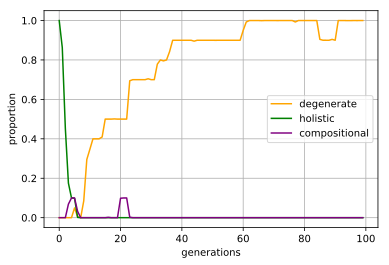

In [30]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = False
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial)[0])
plot_graph(results)


## Questions

1. Try different values for the `communication` and `turnover` parameters. Can you replicate the main results from the [Kirby et al (2015)](https://www.sciencedirect.com/science/article/pii/S0010027715000815?via%3Dihub) paper?

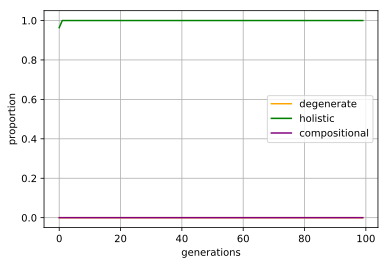

In [31]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = False
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial)[0])
plot_graph(results)


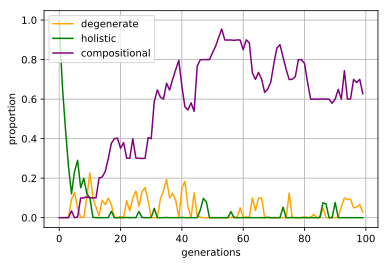

In [32]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True
results = []
for i in range(10):
    results.append(simulation(100, 20, 20, 2, initial)[0])
plot_graph(results)


2. With both communicatively rational speakers and population turnover, what effect does changing the bottleneck size have, and why?

In [18]:
initial = [('02', 'aa'), ('03', 'ab'), ('12', 'bb'), ('13', 'ba')]
communication = True
turnover = True

results_medium = []
for i in range(10):
    results_medium.append(simulation(100, 20, 20, 2, initial)[0])

results_narrow = []
for i in range(10):
    results_narrow.append(simulation(100, 20, 5, 2, initial)[0])

results_wide = []
for i in range(10):
    results_wide.append(simulation(100, 20, 50, 2, initial)[0])


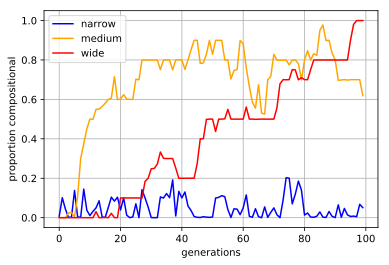

In [19]:
def get_compositional(results):
    compositional_results = []
    for result in results:
        cr = []
        for r in result:
            cr.append(r[3])
        compositional_results.append(cr)
    return compositional_results

def average_values(data):
    result = []
    for i in range(len(data[0])):
        total = 0
        for d in data:
            total += d[i]
        result.append(total/len(data))
    return result


narrow = get_compositional(results_narrow)
plt.plot(average_values(narrow), color='blue', label='narrow')

medium = get_compositional(results_medium)
plt.plot(average_values(medium), color='orange', label='medium')

wide = get_compositional(results_wide)
plt.plot(average_values(wide), color='red', label='wide')


plt.xlabel('generations')
plt.ylabel('proportion compositional')
plt.legend()
plt.grid()

3. Why do we need a `noise` parameter? What happens if the noise is zero? (Hint: think about how you calculate the likelihood of any of the languages if the data you're learning from actually comes from multiple languages.) What about when it is very close to zero or very close to 1?

4. What happens if you initialise the chains with a different type of language, rather than a holistic one? Do all the main results still hold up?